# MACHINE LEARNING — ASSIGNMENT 2

**Topic:** Multi-model classification + Streamlit deployment  
**Planned Dataset:** Credit Card Default (UCI/Kaggle)

---


## STUDENT INFORMATION


- **Name:** HARISH BHATT  
- **StudentID:** 2025AA05578@wilp.bits-pilani.ac.in
- **Program:** M.Tech (AIML/DSE)  
- **Course:** Machine Learning  
- **Assignment:** 2  
- **Submission Date:** 15-Feb-2026  


## 1) Imports & Environment Check

In [4]:
# If running in Colab, uncomment and install dependencies as needed
!pip -q install pandas numpy scikit-learn xgboost matplotlib seaborn joblib

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    precision_score, recall_score,
    f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)


Python: 3.12.7
pandas: 2.2.3


## 2) Load Dataset

In [6]:
# Load pre-split training and testing datasets directly from GitHub

train_url = "https://raw.githubusercontent.com/Harishbhatt07/ML-Assignment-2/main/model/data/train.csv"
test_url = "https://raw.githubusercontent.com/Harishbhatt07/ML-Assignment-2/main/model/data/test.csv"

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

TARGET_COL = "default.payment.next.month"

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

Train shape: (24000, 24)
Test shape: (6000, 24)


In [7]:
import pandas as pd

# Sanity checks (REQUIRED)
MIN_ROWS = 500
MIN_FEATURES = 12

print("Columns:", len(train_df.columns))
print("Rows   :", len(train_df))

# Basic shape checks per assignment requirement
assert len(train_df) >= MIN_ROWS, f"Dataset has {len(train_df)} rows; need at least {MIN_ROWS}."
# features check will be done after defining X (excluding target)

Columns: 24
Rows   : 24000


## 3) Quick EDA / Data Checks (Optional but useful)

In [9]:
# Basic info
display(train_df.describe(include='all').T.head(30))
print("\nMissing values per column (top 20):")
display(train_df.isna().sum().sort_values(ascending=False).head(20))

# Class balance (update target column name if needed)
TARGET_COL = "default.payment.next.month"
if TARGET_COL in train_df.columns:
    display(train_df[TARGET_COL].value_counts(dropna=False))
else:
    print(f"Target column '{TARGET_COL}' not found. Columns are:", list(train_df.columns))

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,24000.0,167364.666667,129511.313151,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,24000.0,1.604750,0.488915,1.0,1.00,2.0,2.00,2.0
EDUCATION,24000.0,1.853792,0.792375,0.0,1.00,2.0,2.00,6.0
MARRIAGE,24000.0,1.552875,0.521903,0.0,1.00,2.0,2.00,3.0
AGE,24000.0,35.432625,9.195256,21.0,28.00,34.0,41.00,75.0
PAY_0,24000.0,-0.014125,1.123155,-2.0,-1.00,0.0,0.00,8.0
PAY_2,24000.0,-0.134083,1.198818,-2.0,-1.00,0.0,0.00,8.0
PAY_3,24000.0,-0.166917,1.194166,-2.0,-1.00,0.0,0.00,8.0
PAY_4,24000.0,-0.221333,1.161924,-2.0,-1.00,0.0,0.00,8.0
PAY_5,24000.0,-0.270333,1.125192,-2.0,-1.00,0.0,0.00,8.0



Missing values per column (top 20):


LIMIT_BAL    0
SEX          0
PAY_AMT6     0
PAY_AMT5     0
PAY_AMT4     0
PAY_AMT3     0
PAY_AMT2     0
PAY_AMT1     0
BILL_AMT6    0
BILL_AMT5    0
BILL_AMT4    0
BILL_AMT3    0
BILL_AMT2    0
BILL_AMT1    0
PAY_6        0
PAY_5        0
PAY_4        0
PAY_3        0
PAY_2        0
PAY_0        0
dtype: int64

default.payment.next.month
0    18691
1     5309
Name: count, dtype: int64

## 4) Preprocessing

In [11]:
# -----------------------------
# Preprocessing for Train/Test
# -----------------------------

TARGET_COL = "default.payment.next.month"  # confirm exact column name

# 4.1 Drop ID column if present (Train)
if "ID" in train_df.columns:
    train_df = train_df.drop(columns=["ID"])

# 4.2 Drop ID column if present (Test)
if "ID" in test_df.columns:
    test_df = test_df.drop(columns=["ID"])

# 4.3 Define X and y separately
X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)

Train X shape: (24000, 23)
Test X shape: (6000, 23)


In [12]:
# Feature/target sanity checks (REQUIRED)

MIN_FEATURES = 12

# 1) Check target exists in both train and test
assert TARGET_COL in train_df.columns, f"Target column not found in train_df: {TARGET_COL}"
assert TARGET_COL in test_df.columns, f"Target column not found in test_df: {TARGET_COL}"

# 2) Check feature count (on train)
n_features = X_train.shape[1]
print("Number of features (X_train):", n_features)
assert n_features >= MIN_FEATURES, f"Dataset has {n_features} features; need at least {MIN_FEATURES}."

# 3) Check train/test have same feature columns (to avoid Streamlit + model issues)
assert list(X_train.columns) == list(X_test.columns), "Train and test feature columns do not match!"

# 4) Target distribution (useful for observations)
print("\nTrain target distribution:")
display(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
display(y_test.value_counts(normalize=True))

Number of features (X_train): 23

Train target distribution:


default.payment.next.month
0    0.778792
1    0.221208
Name: proportion, dtype: float64


Test target distribution:


default.payment.next.month
0    0.778833
1    0.221167
Name: proportion, dtype: float64

## 5) Scaling (for Logistic Regression + KNN; optional for others)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)

Scaled shapes: (24000, 23) (6000, 23)


## 6) Evaluation Utilities

In [16]:
def get_binary_proba(model, X):
    """Return P(class=1) for binary classifiers."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        # Convert decision scores to pseudo-probabilities via min-max scaling as fallback
        scores = model.decision_function(X)
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")
    return proba


def evaluate_model(model, Xtr, Xte, ytr, yte, label_name=None):
    """Fit, predict, compute required metrics for binary classification."""
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    y_prob = get_binary_proba(model, Xte)

    metrics = {
        "Accuracy": accuracy_score(yte, y_pred),
        "AUC": roc_auc_score(yte, y_prob),
        "Precision": precision_score(yte, y_pred, zero_division=0),
        "Recall": recall_score(yte, y_pred, zero_division=0),
        "F1": f1_score(yte, y_pred, zero_division=0),
        "MCC": matthews_corrcoef(yte, y_pred),
    }

    # Confusion matrix + report
    cm = confusion_matrix(yte, y_pred)
    report = classification_report(yte, y_pred, digits=4, zero_division=0)

    return metrics, cm, report

## 7) Train the 6 Required Models

In [18]:
  # =========================
# Train + Evaluate 6 Models
# =========================

results = []
artifacts = {}  # store models + cm/report for later Streamlit use

# 1) Logistic Regression (scaled) — optional: class_weight="balanced"
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
m, cm, report = evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test)
results.append(("Logistic Regression", m))
artifacts["Logistic Regression"] = {"model": lr, "cm": cm, "report": report}

# 2) Decision Tree (unscaled)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
m, cm, report = evaluate_model(dt, X_train, X_test, y_train, y_test)
results.append(("Decision Tree", m))
artifacts["Decision Tree"] = {"model": dt, "cm": cm, "report": report}

# 3) KNN (scaled)
knn = KNeighborsClassifier(n_neighbors=5)
m, cm, report = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test)
results.append(("KNN", m))
artifacts["KNN"] = {"model": knn, "cm": cm, "report": report}

# 4) Naive Bayes (Gaussian) (scaled)
nb = GaussianNB()
m, cm, report = evaluate_model(nb, X_train_scaled, X_test_scaled, y_train, y_test)
results.append(("Naive Bayes", m))
artifacts["Naive Bayes"] = {"model": nb, "cm": cm, "report": report}

# 5) Random Forest (unscaled)
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
m, cm, report = evaluate_model(rf, X_train, X_test, y_train, y_test)
results.append(("Random Forest (Ensemble)", m))
artifacts["Random Forest (Ensemble)"] = {"model": rf, "cm": cm, "report": report}

# 6) XGBoost (unscaled)
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    n_jobs=-1
)
m, cm, report = evaluate_model(xgb, X_train, X_test, y_train, y_test)
results.append(("XGBoost (Ensemble)", m))
artifacts["XGBoost (Ensemble)"] = {"model": xgb, "cm": cm, "report": report}

# Comparison table
results_df = pd.DataFrame([r[1] for r in results], index=[r[0] for r in results])
display(results_df)

,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.807667,0.707636,0.686825,0.239638,0.355307,0.324443
Decision Tree,0.714500,0.607451,0.369418,0.411454,0.389305,0.204216
KNN,0.792833,0.701435,0.548724,0.356443,0.432161,0.323267
Naive Bayes,0.752500,0.724930,0.451474,0.553881,0.497462,0.338620
Random Forest (Ensemble),0.816833,0.774145,0.659664,0.354936,0.461538,0.388303
XGBoost (Ensemble),0.816667,0.777358,0.655267,0.360965,0.465500,0.389585


In [19]:
# Results validation (REQUIRED — prevent accidental 0.0 / missing metrics)

REQUIRED_MODELS = [
    "Logistic Regression",
    "Decision Tree",
    "KNN",
    "Naive Bayes",
    "Random Forest (Ensemble)",
    "XGBoost (Ensemble)"
]

# Check all required models present
missing = [m for m in REQUIRED_MODELS if m not in results_df.index]
assert not missing, f"Missing model results for: {missing}"

# Check for NaNs
assert not results_df.isna().any().any(), "Some metrics are NaN. Check AUC/probabilities."

# Check metrics not all zeros
for col in results_df.columns:
    assert (results_df[col] != 0).any(), f"Column {col} looks all zeros — did metrics compute correctly?"

print("✅ Results table contains all required models and valid metric values.")
display(results_df)

✅ Results table contains all required models and valid metric values.


,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.807667,0.707636,0.686825,0.239638,0.355307,0.324443
Decision Tree,0.714500,0.607451,0.369418,0.411454,0.389305,0.204216
KNN,0.792833,0.701435,0.548724,0.356443,0.432161,0.323267
Naive Bayes,0.752500,0.724930,0.451474,0.553881,0.497462,0.338620
Random Forest (Ensemble),0.816833,0.774145,0.659664,0.354936,0.461538,0.388303
XGBoost (Ensemble),0.816667,0.777358,0.655267,0.360965,0.465500,0.389585


## 8) Plots and Visualization

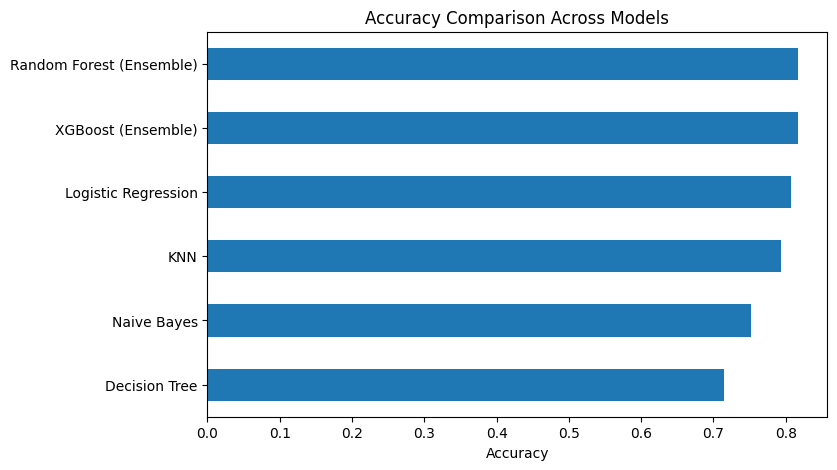

In [21]:
# Bar Plot — Accuracy Comparison
plt.figure(figsize=(8,5))
results_df["Accuracy"].sort_values().plot(kind="barh")
plt.title("Accuracy Comparison Across Models")
plt.xlabel("Accuracy")
plt.show()

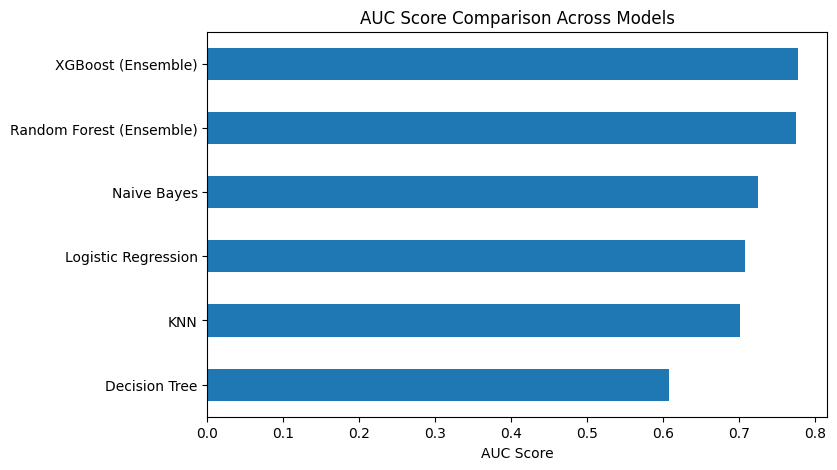

In [22]:
#Bar Plot — AUC Comparison
plt.figure(figsize=(8,5))
results_df["AUC"].sort_values().plot(kind="barh")
plt.title("AUC Score Comparison Across Models")
plt.xlabel("AUC Score")
plt.show()

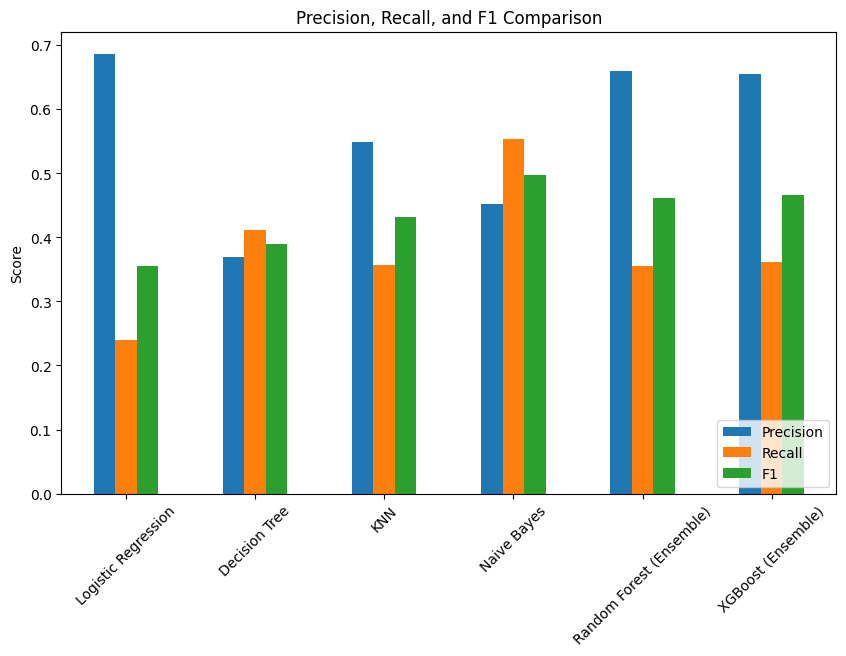

In [23]:
#Grouped Bar Chart — Precision, Recall, F1 Comparison
metrics_to_plot = ["Precision", "Recall", "F1"]

results_df[metrics_to_plot].plot(kind="bar", figsize=(10,6))
plt.title("Precision, Recall, and F1 Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

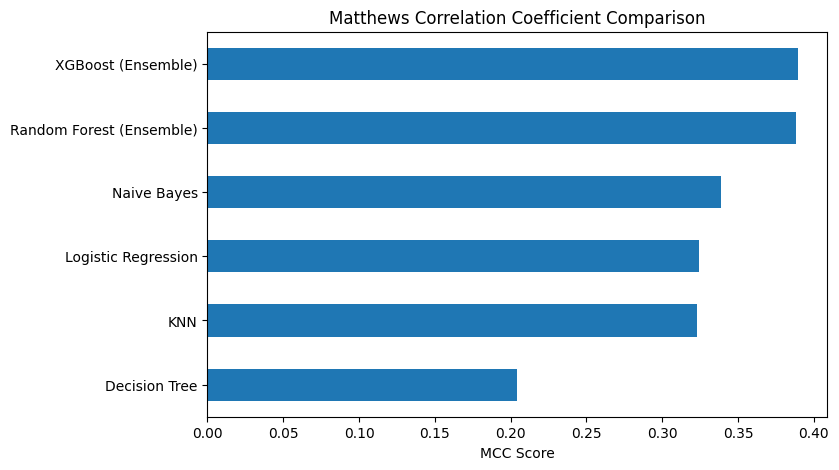

In [24]:
# MCC Comparison Plot (Advanced Metric)
plt.figure(figsize=(8,5))
results_df["MCC"].sort_values().plot(kind="barh")
plt.title("Matthews Correlation Coefficient Comparison")
plt.xlabel("MCC Score")
plt.show()

## 9) Identify the Best Model

In [26]:
# You can choose based on AUC, MCC, or F1. Here we pick best by AUC.
best_model_name = results_df["AUC"].idxmax()
best_model = artifacts[best_model_name]["model"]

print("Best model by AUC:", best_model_name)

Best model by AUC: XGBoost (Ensemble)


## 10) Visuals: Confusion Matrix & Report (for all models)

Model: Logistic Regression
Classification Report:

              precision    recall  f1-score   support

           0     0.8178    0.9690    0.8870      4673
           1     0.6868    0.2396    0.3553      1327

    accuracy                         0.8077      6000
   macro avg     0.7523    0.6043    0.6211      6000
weighted avg     0.7888    0.8077    0.7694      6000



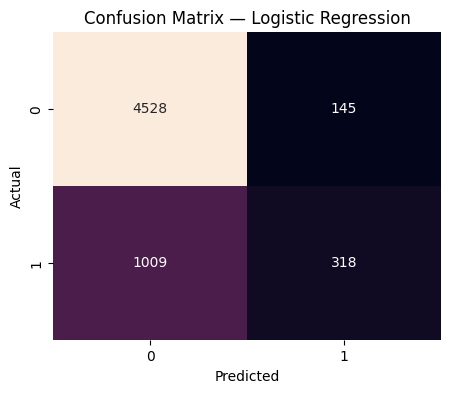

Model: Decision Tree
Classification Report:

              precision    recall  f1-score   support

           0     0.8273    0.8006    0.8137      4673
           1     0.3694    0.4115    0.3893      1327

    accuracy                         0.7145      6000
   macro avg     0.5984    0.6060    0.6015      6000
weighted avg     0.7260    0.7145    0.7198      6000



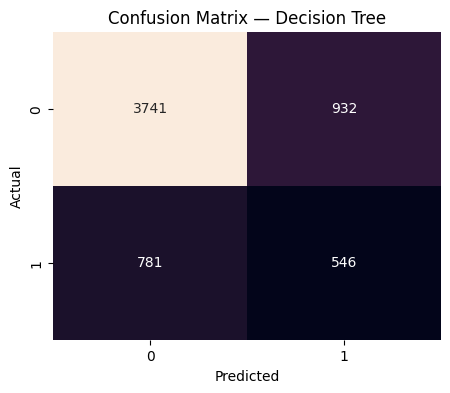

Model: KNN
Classification Report:

              precision    recall  f1-score   support

           0     0.8338    0.9168    0.8733      4673
           1     0.5487    0.3564    0.4322      1327

    accuracy                         0.7928      6000
   macro avg     0.6913    0.6366    0.6527      6000
weighted avg     0.7707    0.7928    0.7757      6000



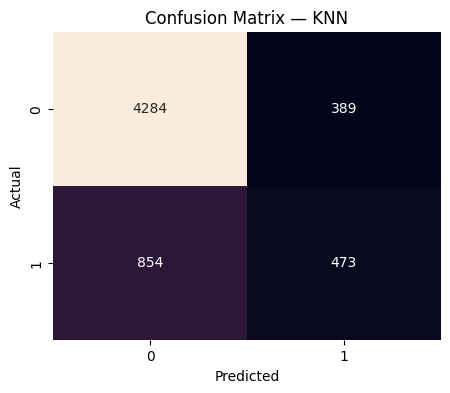

Model: Naive Bayes
Classification Report:

              precision    recall  f1-score   support

           0     0.8646    0.8089    0.8358      4673
           1     0.4515    0.5539    0.4975      1327

    accuracy                         0.7525      6000
   macro avg     0.6580    0.6814    0.6666      6000
weighted avg     0.7732    0.7525    0.7610      6000



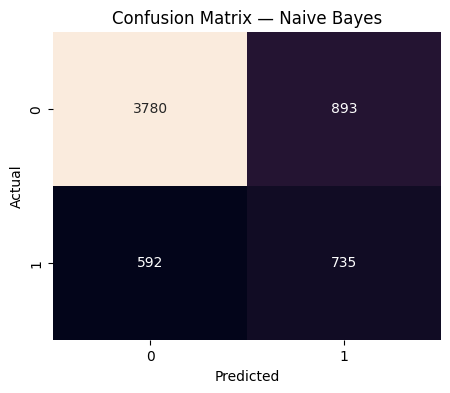

Model: Random Forest (Ensemble)
Classification Report:

              precision    recall  f1-score   support

           0     0.8381    0.9480    0.8896      4673
           1     0.6597    0.3549    0.4615      1327

    accuracy                         0.8168      6000
   macro avg     0.7489    0.6515    0.6756      6000
weighted avg     0.7986    0.8168    0.7950      6000



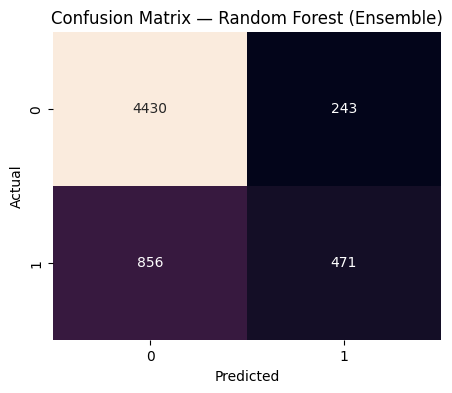

Model: XGBoost (Ensemble)
Classification Report:

              precision    recall  f1-score   support

           0     0.8391    0.9461    0.8894      4673
           1     0.6553    0.3610    0.4655      1327

    accuracy                         0.8167      6000
   macro avg     0.7472    0.6535    0.6774      6000
weighted avg     0.7984    0.8167    0.7956      6000



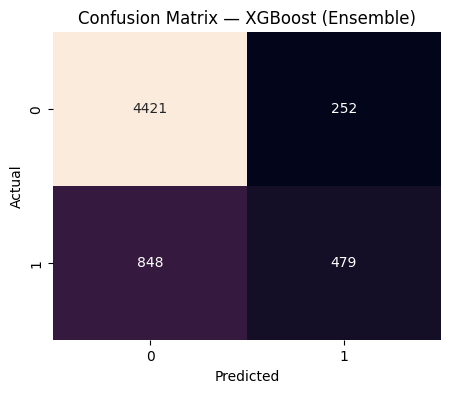

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, obj in artifacts.items():

    cm = obj["cm"]
    report = obj["report"]

    print("="*60)
    print(f"Model: {model_name}")
    print("="*60)
    print("Classification Report:\n")
    print(report)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.show()

## 11) Save Artifacts for Streamlit

In [30]:
# =========================
# Save Artifacts for Streamlit
# =========================
import os, joblib

os.makedirs("model", exist_ok=True)

# Save scaler (needed for LR + KNN + Naive Bayes)
joblib.dump(scaler, "model/scaler.pkl")

# Save each model
for name, obj in artifacts.items():
    safe_name = (
        name.lower()
        .replace(" ", "_")
        .replace("(", "")
        .replace(")", "")
        .replace("/", "_")
    )
    joblib.dump(obj["model"], f"model/{safe_name}.pkl")

print("Saved models + scaler into ./model/")

Saved models + scaler into ./model/


## 12) Observations


## Comparison Table of Evaluation Metrics

| ML Model Name | Accuracy | AUC | Precision | Recall | F1 | MCC |
|---------------|----------|------|-----------|--------|------|------|
| Logistic Regression | 0.8077 | 0.7076 | 0.6868 | 0.2396 | 0.3553 | 0.3244 |
| Decision Tree | 0.7145 | 0.6075 | 0.3694 | 0.4115 | 0.3893 | 0.2042 |
| KNN | 0.7928 | 0.7014 | 0.5487 | 0.3564 | 0.4322 | 0.3233 |
| Naive Bayes | 0.7525 | 0.7249 | 0.4515 | 0.5539 | 0.4975 | 0.3386 |
| Random Forest (Ensemble) | 0.8168 |	0.7741 |	0.6597 |	0.3549 |	0.4615 |	0.3883 |
| XGBoost (Ensemble) | **0.8167** | **0.7774** | 0.6553 | 0.3610 | 0.4655 | **0.3896** |

---

## Observations on Model Performance

| ML Model Name | Observation about Model Performance |
|---------------|-------------------------------------|
| Logistic Regression | Achieved good overall accuracy and high precision but very low recall, indicating conservative prediction of default cases. It tends to miss many actual defaulters. |
| Decision Tree | Showed the weakest overall performance across most metrics, likely due to overfitting and limited generalization capability. |
| KNN | Delivered moderate performance with balanced precision and recall but lower discrimination ability compared to ensemble models. |
| Naive Bayes | Achieved the highest recall among all models, indicating better sensitivity in detecting defaulters, though with reduced precision. |
| Random Forest (Ensemble) | Demonstrated strong performance with high AUC and MCC, indicating improved stability and generalization compared to individual models. |
| XGBoost (Ensemble) | Achieved the best overall performance with highest AUC and MCC. It provides superior class separation and balanced predictive capability. |

---

## Final Model Selection

Based on the comparison of evaluation metrics, **XGBoost** is selected as the best-performing model due to its superior AUC and MCC scores, indicating better overall classification quality and balanced performance on imbalanced data.